In [1]:
import pandas as pd
from functools import partial
import numpy as np
from multiprocessing import Pool
import os
import matplotlib.pyplot as plt
class miDataFrame():

    def __init__(self,url=[],n_cores=1,emisiones=pd.DataFrame):
        self.url = url
        self.n_cores = n_cores
        self.emisiones = emisiones

    def generarDF(self):
        pool = Pool(self.n_cores)
        self.emisiones = pd.concat(pool.map(partial(pd.read_csv, sep=';'),self.url))

    def filtrarDataFrame(self):
        def genListaFilt():
            r=range(1,32)
            return list(map(lambda x: f'V0{x}' if x<10 else f'V{x}',r))+['PUNTO_MUESTREO']
        self.emisiones = self.emisiones.iloc[:,2:]
        self.emisiones.drop(genListaFilt(), axis='columns', inplace=True)

    def reestructurarDF(self):
        self.emisiones = self.emisiones.melt(id_vars=['ESTACION', 'MAGNITUD', 'ANO', 'MES'], 
                                             var_name='DIA', value_name='VALOR')

    def agregarFecha(self):
        self.emisiones['DIA'] = self.emisiones.DIA.str.strip('D')
        self.emisiones['FECHA'] = self.emisiones.ANO.apply(str) + '/' + self.emisiones.MES.apply(str) + '/' + self.emisiones.DIA.apply(str)
        self.emisiones['FECHA'] = pd.to_datetime(self.emisiones.FECHA, format='%Y/%m/%d', infer_datetime_format=True, errors='coerce')
    
    def delNotValid(self):
        self.emisiones = self.emisiones.drop(self.emisiones[np.isnat(self.emisiones.FECHA)].index)
        self.emisiones.sort_values(['ESTACION', 'MAGNITUD', 'FECHA'])

    def mostrarEstMag(self):
        print('Estaciones:', self.emisiones.ESTACION.unique())
        print('Contaminantes:', self.emisiones.MAGNITUD.unique())

    def mostrarDescriptivoContaminante(self):
        return self.emisiones.groupby('MAGNITUD').VALOR.describe()
    
    def mostrarDescritivoContaminanteDistrito(self):
        return self.emisiones.groupby(['ESTACION', 'MAGNITUD']).VALOR.describe()

    def evolucion_mensual(self,cont, año):
        return self.emisiones[(self.emisiones.MAGNITUD == cont) & (self.emisiones.ANO == año)].groupby(['ESTACION', 'MES']).VALOR.mean().unstack('MES')

    def evolucion_diaria(self,estacion, mes):
        return self.emisiones[(self.emisiones.ESTACION == estacion) & (self.emisiones.MES == mes)].groupby(['MAGNITUD', 'DIA']).VALOR.mean().unstack('DIA')

    #------
    def evolucionMagnitudRange(self,magnitud, desde, hasta):
        self.emisiones['NOMBRE ESTACION'] = self.emisiones['ESTACION'].apply(lambda x: self.emisiones.ESTACION[x])
        df1 = self.emisiones[(self.emisiones['MAGNITUD'] == self.emisiones.MAGNITUD) & (self.emisiones.FECHA >= desde) & (self.emisiones.FECHA <= hasta)]
        df1.set_index('FECHA', inplace = True)
        fig, ax = plt.subplots(figsize=(22,6))
        df1.groupby('ESTACION')['VALOR'].plot(legend = True)
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        plt.show()

    #-----
    def evolucionMagnitud(self,magnitud):
        #self.emisiones['NOMBRE ESTACION'] = self.emisiones['ESTACION'].apply(lambda x: self.emisiones.ESTACION[x])
        df1 = self.emisiones[(self.emisiones['MAGNITUD'] == self.emisiones.MAGNITUD)]
        df1.set_index('FECHA', inplace = True)
        fig, ax = plt.subplots(figsize=(22,6))
        df1.groupby('ESTACION')['VALOR'].plot(legend = True)
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        plt.show()

# Crear Objeto

In [2]:
URL = ["/content/drive/MyDrive/CursoCapacitacion/proyectoIntegrador/emisiones-2016.csv",
       "/content/drive/MyDrive/CursoCapacitacion/proyectoIntegrador/emisiones-2017.csv",
       "/content/drive/MyDrive/CursoCapacitacion/proyectoIntegrador/emisiones-2018.csv",
       "/content/drive/MyDrive/CursoCapacitacion/proyectoIntegrador/emisiones-2019.csv"]
n_cores=os.cpu_count()-1
miClase = miDataFrame(URL,n_cores)

# Generar un DataFrame con los datos de los cuatro ficheros.

In [3]:
miClase.generarDF()
miClase.emisiones.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,D01,V01,D02,...,D27,V27,D28,V28,D29,V29,D30,V30,D31,V31
0,28,79,4,1,28079004_1_38,2016,1,8.0,V,7.0,...,9.0,V,7.0,V,8.0,V,9.0,V,9.0,V
1,28,79,4,1,28079004_1_38,2016,2,12.0,V,13.0,...,7.0,V,8.0,V,9.0,V,0.0,N,0.0,N
2,28,79,4,1,28079004_1_38,2016,3,11.0,V,10.0,...,8.0,V,7.0,V,8.0,V,10.0,V,8.0,V
3,28,79,4,1,28079004_1_38,2016,4,8.0,V,9.0,...,9.0,V,8.0,V,8.0,V,8.0,V,0.0,N
4,28,79,4,1,28079004_1_38,2016,5,7.0,V,8.0,...,7.0,V,7.0,V,7.0,V,7.0,V,7.0,V


# Filtrar las columnas del DataFrame para quedarse con las columnas ESTACION, MAGNITUD, AÑO, MES y las correspondientes a los días D01, D02, etc.

In [4]:
miClase.filtrarDataFrame()
miClase.emisiones.head()

,ESTACION,MAGNITUD,ANO,MES,D01,D02,D03,D04,D05,D06,...,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31
0,4,1,2016,1,8.0,7.0,6.0,6.0,7.0,6.0,...,10.0,11.0,11.0,13.0,12.0,9.0,7.0,8.0,9.0,9.0
1,4,1,2016,2,12.0,13.0,9.0,9.0,11.0,9.0,...,11.0,10.0,9.0,8.0,7.0,7.0,8.0,9.0,0.0,0.0
2,4,1,2016,3,11.0,10.0,9.0,9.0,7.0,8.0,...,8.0,8.0,9.0,9.0,9.0,8.0,7.0,8.0,10.0,8.0
3,4,1,2016,4,8.0,9.0,9.0,8.0,8.0,9.0,...,8.0,8.0,8.0,8.0,9.0,9.0,8.0,8.0,8.0,0.0
4,4,1,2016,5,7.0,8.0,9.0,9.0,8.0,8.0,...,7.0,7.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0


# Reestructurar el DataFrame para que los valores de los contaminantes de las columnas de los días aparezcan en una única columna.

In [5]:
miClase.reestructurarDF()
miClase.emisiones

,ESTACION,MAGNITUD,ANO,MES,DIA,VALOR
0,4,1,2016,1,D01,8.0
1,4,1,2016,2,D01,12.0
2,4,1,2016,3,D01,11.0
3,4,1,2016,4,D01,8.0
4,4,1,2016,5,D01,7.0
...,...,...,...,...,...,...
225241,60,14,2019,8,D31,98.0
225242,60,14,2019,9,D31,0.0
225243,60,14,2019,10,D31,47.0
225244,60,14,2019,11,D31,0.0


# Añadir una columna con la fecha a partir de la concatenación del año, el mes y el día (usar el módulo datetime).

In [6]:
miClase.agregarFecha()
miClase.emisiones

,ESTACION,MAGNITUD,ANO,MES,DIA,VALOR,FECHA
0,4,1,2016,1,01,8.0,2016-01-01
1,4,1,2016,2,01,12.0,2016-02-01
2,4,1,2016,3,01,11.0,2016-03-01
3,4,1,2016,4,01,8.0,2016-04-01
4,4,1,2016,5,01,7.0,2016-05-01
...,...,...,...,...,...,...,...
225241,60,14,2019,8,31,98.0,2019-08-31
225242,60,14,2019,9,31,0.0,NaT
225243,60,14,2019,10,31,47.0,2019-10-31
225244,60,14,2019,11,31,0.0,NaT


# Eliminar las filas con fechas no válidas (utilizar la función isnat del módulo numpy) y ordenar el DataFrame por estaciones, contaminantes y fecha.

In [7]:
miClase.delNotValid()
miClase.emisiones

,ESTACION,MAGNITUD,ANO,MES,DIA,VALOR,FECHA
0,4,1,2016,1,01,8.0,2016-01-01
1,4,1,2016,2,01,12.0,2016-02-01
2,4,1,2016,3,01,11.0,2016-03-01
3,4,1,2016,4,01,8.0,2016-04-01
4,4,1,2016,5,01,7.0,2016-05-01
...,...,...,...,...,...,...,...
225238,60,14,2019,5,31,85.0,2019-05-31
225240,60,14,2019,7,31,92.0,2019-07-31
225241,60,14,2019,8,31,98.0,2019-08-31
225243,60,14,2019,10,31,47.0,2019-10-31


# Mostrar por pantalla las estaciones y los contaminantes disponibles en el DataFrame

In [8]:
miClase.mostrarEstMag()
miClase.emisiones

Estaciones: [ 4  8 11 16 17 18 24 27 35 36 38 39 40 47 48 49 50 54 55 56 57 58 59 60]
Contaminantes: [ 1  6  7  8 12  9 10 14 20 30 35 42 43 44]


,ESTACION,MAGNITUD,ANO,MES,DIA,VALOR,FECHA
0,4,1,2016,1,01,8.0,2016-01-01
1,4,1,2016,2,01,12.0,2016-02-01
2,4,1,2016,3,01,11.0,2016-03-01
3,4,1,2016,4,01,8.0,2016-04-01
4,4,1,2016,5,01,7.0,2016-05-01
...,...,...,...,...,...,...,...
225238,60,14,2019,5,31,85.0,2019-05-31
225240,60,14,2019,7,31,92.0,2019-07-31
225241,60,14,2019,8,31,98.0,2019-08-31
225243,60,14,2019,10,31,47.0,2019-10-31


# Mostrar un resumen descriptivo (mímino, máximo, media, etc) para cada contaminante.

In [9]:
miClase.mostrarDescriptivoContaminante()
miClase.emisiones

,ESTACION,MAGNITUD,ANO,MES,DIA,VALOR,FECHA
0,4,1,2016,1,01,8.0,2016-01-01
1,4,1,2016,2,01,12.0,2016-02-01
2,4,1,2016,3,01,11.0,2016-03-01
3,4,1,2016,4,01,8.0,2016-04-01
4,4,1,2016,5,01,7.0,2016-05-01
...,...,...,...,...,...,...,...
225238,60,14,2019,5,31,85.0,2019-05-31
225240,60,14,2019,7,31,92.0,2019-07-31
225241,60,14,2019,8,31,98.0,2019-08-31
225243,60,14,2019,10,31,47.0,2019-10-31


# Mostrar un resumen descriptivo para cada contaminente por distritos.

In [10]:
miClase.mostrarDescritivoContaminanteDistrito()
miClase.emisiones

,ESTACION,MAGNITUD,ANO,MES,DIA,VALOR,FECHA
0,4,1,2016,1,01,8.0,2016-01-01
1,4,1,2016,2,01,12.0,2016-02-01
2,4,1,2016,3,01,11.0,2016-03-01
3,4,1,2016,4,01,8.0,2016-04-01
4,4,1,2016,5,01,7.0,2016-05-01
...,...,...,...,...,...,...,...
225238,60,14,2019,5,31,85.0,2019-05-31
225240,60,14,2019,7,31,92.0,2019-07-31
225241,60,14,2019,8,31,98.0,2019-08-31
225243,60,14,2019,10,31,47.0,2019-10-31


# Crear una función que devuelva las emisiones medias mensuales de un contaminante y un año dados para todas las estaciones.

In [11]:
miClase.evolucion_mensual(1, 2016)

MES,1,2,3,4,5,6,7,8,9,10,11,12
ESTACION,,,,,,,,,,,,
4,8.354839,8.551724,8.612903,8.066667,7.354839,7.266667,7.032258,7.000000,8.100000,7.387097,4.033333,8.129032
8,16.387097,17.827586,16.838710,15.400000,14.967742,17.333333,8.548387,5.806452,8.866667,11.064516,8.966667,10.032258
17,8.387097,8.551724,9.290323,16.800000,15.225806,15.333333,8.354839,7.870968,9.066667,19.064516,11.900000,14.548387
18,3.516129,3.793103,3.838710,3.266667,3.580645,4.033333,3.548387,9.129032,7.333333,6.741935,5.166667,6.806452
24,2.387097,2.172414,2.129032,2.066667,2.000000,2.100000,2.516129,2.580645,2.500000,2.774194,2.966667,3.709677
35,8.161290,10.517241,10.677419,12.433333,13.000000,16.466667,12.741935,11.612903,13.733333,10.709677,8.566667,4.032258
36,10.161290,7.310345,7.322581,6.133333,5.032258,5.933333,6.193548,7.096774,7.966667,7.322581,12.066667,4.548387
38,8.677419,4.068966,3.838710,2.766667,2.193548,2.133333,1.774194,1.709677,2.166667,3.032258,4.766667,7.516129
40,6.096774,5.793103,6.645161,5.633333,4.806452,5.300000,3.645161,3.419355,4.533333,6.419355,8.000000,11.161290


# Crear una función que reciba un mes y una estación de medición y devuelva un diccionario con las medias de las magnitudes medidas por la estación durante ese mes

In [12]:
miClase.evolucion_diaria(4, 10)

DIA,01,02,03,04,05,06,07,08,09,10,...,22,23,24,25,26,27,28,29,30,31
MAGNITUD,,,,,,,,,,,,,,,,,,,,,
1,8.750,8.750,9.500,9.250,9.75,9.000,9.25,10.500,9.00,8.500,...,6.500,6.750,7.75,9.00,10.250,7.750,19.750,157.000,7.000,7.000
6,0.375,0.375,0.525,0.525,0.55,0.475,0.45,0.525,0.45,0.475,...,0.425,0.425,0.55,0.70,0.775,0.625,0.475,0.525,0.525,0.525
7,34.750,35.000,60.250,60.000,61.50,46.000,41.50,58.000,43.50,44.000,...,37.000,34.750,60.50,94.75,113.000,71.500,52.500,54.250,58.250,55.000
8,44.000,46.500,64.500,67.750,72.75,63.000,52.00,58.500,53.25,57.250,...,42.750,44.750,59.50,63.50,67.750,50.750,47.000,47.750,49.500,50.500
12,97.000,100.000,156.500,159.750,166.50,133.500,115.75,147.750,119.75,124.750,...,99.500,98.000,152.50,208.75,240.750,160.250,127.250,131.250,139.000,135.000


# Crear una función que reciba un rango de fechas y una magnitud y genere un gráfico con la evolución diaria de la magnitud para cada estación de medición en las fechas indicadas.

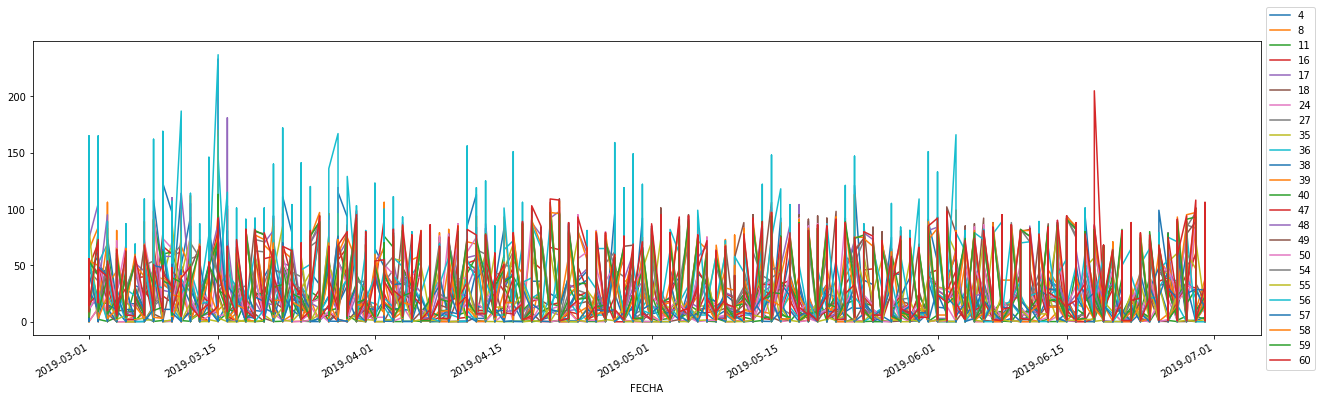

In [13]:
miClase.evolucionMagnitudRange('12', '2019-03-01', '2019-06-30')

# Crear una función que reciba una magnitud y genere un gráfico con las medias mensuales dentro de Madrid Central y fuera de ella.


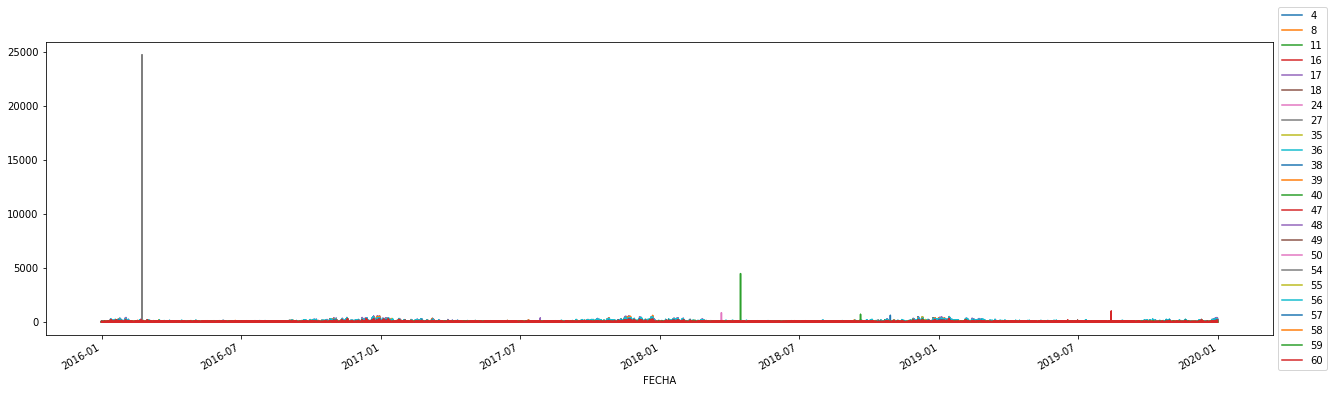

In [14]:
miClase.evolucionMagnitud('1')